# Description:

This notebook is calulating the ODE for the nine mode model created by Eckhardt et. al.:

**A low-dimensional model for turbulent shear flows**  
https://iopscience.iop.org/article/10.1088/1367-2630/6/1/056

The evaluation of the accuring integrals that are optained by an galerkin projection are symbolically solved with the use of the **sympy** package.

In [2]:
from IPython.display import display

import re
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools
import pickle
from tqdm.notebook import tqdm
from multiprocessing import Pool


import sympy
from sympy import N
from sympy import Function
from sympy import integrate
from sympy import simplify, trigsimp
from sympy import symbols, Symbol, Matrix, integrate
from sympy import sin, cos, sqrt, pi
from sympy.vector import gradient
from sympy.utilities.lambdify import lambdify


# you can remove that line if you sure
# another sympy version has no
# relevant changes in syntax
assert sympy.__version__ == '1.5.1'

## Set up folderstucture

In [3]:
for p in ["expressions/I1","expressions/I2","expressions/I3"]:
    if not os.path.isdir(p):
        os.makedirs(p)

## Define variables and constants

In [4]:
x, y, z = symbols('x y z')

a = Symbol(r'\alpha', nonzero=True,finite=True)
b = Symbol(r'\beta', nonzero=True,finite=True)
g = Symbol(r'\gamma', nonzero=True,finite=True)

Re = Symbol("Re")

# Navier Stokes solver

We are going to devide the calculation into three steps and solving the expressions I1, I2 and I3 seperatly (Compare to eq. 20 in the puplication):

\begin{equation}
\begin{split}
\left(
\frac{8\pi^2}{\alpha \gamma}
\right)
\dot{a}_m
=
-\sum_{m,l} a_m a_l  \int_\Omega \underbrace{\left[ (\boldsymbol{u}_m \cdot \nabla)\boldsymbol{u}_l\right] \cdot \boldsymbol{u}_n}_{\text{I1}} \text{ }d^3\boldsymbol{x}\\
+ \frac{1}{Re}\sum_{m} a_m  \int_\Omega \underbrace{(\nabla^2 \boldsymbol{u}_m) \cdot \boldsymbol{u}_n}_{\text{I2}} \text{ }d^3\boldsymbol{x}\\
+ \int_\Omega \underbrace{\boldsymbol{F} \cdot \boldsymbol{u}_n}_{\text{I3}} \text{ }d^3\boldsymbol{x}
\end{split}
\end{equation}

here the expanded calculation for the parts are defined:

In [5]:
def calc_I1(um, ul, un):
    
    dx_ulx = ul[0].diff(x)
    dy_ulx = ul[0].diff(y)
    dz_ulx = ul[0].diff(z)
    
    dx_uly = ul[1].diff(x)
    dy_uly = ul[1].diff(y)
    dz_uly = ul[1].diff(z)
    
    dx_ulz = ul[2].diff(x)
    dy_ulz = ul[2].diff(y)
    dz_ulz = ul[2].diff(z)
    
    temp_vector = Matrix([
                         [um[0] * dx_ulx + um[1] * dy_ulx + um[2] * dz_ulx],
                         [um[0] * dx_uly + um[1] * dy_uly + um[2] * dz_uly],
                         [um[0] * dx_ulz + um[1] * dy_ulz + um[2] * dz_ulz]
                         ])
    
    return temp_vector.dot(un)


def calc_I2(um, un):
    
    
    d2x_ulx = um[0].diff(x,2)
    d2y_ulx = um[0].diff(y,2)
    d2z_ulx = um[0].diff(z,2)
    
    d2x_uly = um[1].diff(x,2)
    d2y_uly = um[1].diff(y,2)
    d2z_uly = um[1].diff(z,2)
    
    d2x_ulz = um[2].diff(x,2)
    d2y_ulz = um[2].diff(y,2)
    d2z_ulz = um[2].diff(z,2)
    
    
    temp_vector = Matrix([
                         [d2x_ulx + d2y_ulx + d2z_ulx],
                         [d2x_uly + d2y_uly + d2z_uly],
                         [d2x_ulz + d2y_ulz + d2z_ulz],
                         ])

    return temp_vector.dot(un)


def calc_I3(un, force):
    return force.dot(un)


def integrate_over_volumne(exp):
    return integrate(exp,(x, 0, 2*pi/a),(y, -1, 1),(z, 0, 2*pi/g))

# Define the nine modes and the driving force

In [6]:
force = Matrix([
               [sqrt(2)*pi**2/(4*Re)*sin(pi*y/2)],
               [0],
               [0]
               ])
force

Matrix([
[sqrt(2)*pi**2*sin(pi*y/2)/(4*Re)],
[                               0],
[                               0]])

In [7]:
u1 = Matrix([
            [sqrt(2)*sin(pi * y/2)],
            [0],
            [0]
            ])

u2 = Matrix([
            [4/sqrt(3)*cos(pi * y/2)**2 * cos(g*z)],
            [0],
            [0]
            ])

u3 = Matrix([
            [0],
            [2*g*cos(pi*y/2)*cos(g*z)],
            [pi*sin(pi*y/2)*sin(g*z)]
            ])

u3 *= 2/sqrt(4*g**2 + pi**2)

u4 = Matrix([
            [0],
            [0],
            [4/sqrt(3)*cos(a*x)*cos(pi*y/2)**2]
            ])


u5 = Matrix([
            [0],
            [0],
            [2*sin(a*x)*sin(pi*y/2)]
            ])

u6 = Matrix([
            [-g*cos(a*x)* cos(pi*y/2)**2 * sin(g*z)],
            [0],
            [a*sin(a*x)*cos(pi*y/2)**2*cos(g*z)]
            ])

u6 *= 4*sqrt(2)/sqrt(3*(a**2+g**2))

u7 = Matrix([
            [g*sin(a*x)*sin(pi*y/2)*sin(g*z)],
            [0],
            [a*cos(a*x)*sin(pi*y/2)*cos(g*z)]
            ])

u7 *= 2*sqrt(2)/sqrt(a**2+g**2)

u8 = Matrix([
            [pi*a*sin(a*x)*sin(pi*y/2)*sin(g*z)],
            [2*(a**2+g**2)*cos(a*x)*cos(pi*y/2)*sin(g*z)],
            [-pi*g*cos(a*x)*sin(pi*y/2)*cos(g*z)]
            ])

u8 *= 2*sqrt(2)/sqrt((a**2+g**2)*(4*a**2+4*g**2+pi**2))

u9 = Matrix([
            [sqrt(2)*sin(3*pi*y/2)],
            [0],
            [0]
            ])

list_of_u = [u1,u2,u3,u4,u5,u6,u7,u8,u9]

## Check if the modes are divergenz free

In [8]:
def divergence(f, x):
    return sum(fi.diff(xi) for fi, xi in zip(f, x))

for u in list_of_u:
    div = divergence(u, [x,y,z])
    div = simplify(div)
    div = trigsimp(div)
    
    assert div == 0

# Display the modes

In [9]:
for u in list_of_u:
    display(u)

Matrix([
[sqrt(2)*sin(pi*y/2)],
[                  0],
[                  0]])

Matrix([
[4*sqrt(3)*cos(pi*y/2)**2*cos(\gamma*z)/3],
[                                       0],
[                                       0]])

Matrix([
[                                                           0],
[4*\gamma*cos(pi*y/2)*cos(\gamma*z)/sqrt(4*\gamma**2 + pi**2)],
[    2*pi*sin(pi*y/2)*sin(\gamma*z)/sqrt(4*\gamma**2 + pi**2)]])

Matrix([
[                                       0],
[                                       0],
[4*sqrt(3)*cos(pi*y/2)**2*cos(\alpha*x)/3]])

Matrix([
[                          0],
[                          0],
[2*sin(pi*y/2)*sin(\alpha*x)]])

Matrix([
[-4*sqrt(2)*\gamma*sin(\gamma*z)*cos(pi*y/2)**2*cos(\alpha*x)/sqrt(3*\alpha**2 + 3*\gamma**2)],
[                                                                                           0],
[ 4*sqrt(2)*\alpha*sin(\alpha*x)*cos(pi*y/2)**2*cos(\gamma*z)/sqrt(3*\alpha**2 + 3*\gamma**2)]])

Matrix([
[2*sqrt(2)*\gamma*sin(pi*y/2)*sin(\alpha*x)*sin(\gamma*z)/sqrt(\alpha**2 + \gamma**2)],
[                                                                                   0],
[2*sqrt(2)*\alpha*sin(pi*y/2)*cos(\alpha*x)*cos(\gamma*z)/sqrt(\alpha**2 + \gamma**2)]])

Matrix([
[                  2*sqrt(2)*pi*\alpha*sin(pi*y/2)*sin(\alpha*x)*sin(\gamma*z)/(sqrt(\alpha**2 + \gamma**2)*sqrt(4*\alpha**2 + 4*\gamma**2 + pi**2))],
[2*sqrt(2)*(2*\alpha**2 + 2*\gamma**2)*sin(\gamma*z)*cos(pi*y/2)*cos(\alpha*x)/(sqrt(\alpha**2 + \gamma**2)*sqrt(4*\alpha**2 + 4*\gamma**2 + pi**2))],
[                 -2*sqrt(2)*pi*\gamma*sin(pi*y/2)*cos(\alpha*x)*cos(\gamma*z)/(sqrt(\alpha**2 + \gamma**2)*sqrt(4*\alpha**2 + 4*\gamma**2 + pi**2))]])

Matrix([
[sqrt(2)*sin(3*pi*y/2)],
[                    0],
[                    0]])

# Calculate I1 over all posible permutations
It will check if the result is allready in the folder ./expressions. If you want to re-run the calculation make sure those folders are emtpy.

In [10]:
def wrapper(indices):
    
    m,l,n = indices
    
    out_path = "expressions/I1/I1_m={}_l={}_n={}.pkl".format(m,l,n)
    
    if not os.path.isfile(out_path):
    
        nonlin = calc_I1(list_of_u[m],list_of_u[l],list_of_u[n])
        nonlin = simplify(nonlin)
        nonlin = trigsimp(nonlin)

        integral = integrate_over_volumne(nonlin)
        integral = simplify(integral)
        integral = trigsimp(integral) 

        with open(out_path, "w") as outf:
            pickle.dump(integral, outf)
    
    
# List all the differnt permutations for the indices
todolist = [p for p in itertools.product(range(9), repeat=3)]

print("Jobs to do: {}".format(len(todolist)))

# # Run jobs on one thread
# for item in tqdm(todolist):
#     wrapper(item)

# do the calculations in parallel
pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(wrapper, todolist), total=len(todolist)):
    pass

Jobs to do: 729


### Check Couplings

Those are the nonlinear couplings of the modes. Compare to **Table 1** in the puplication.

In [11]:
all_couplings = glob.glob("expressions/I1/*.pkl")

table = np.zeros((9,9,9))

for coupling in all_couplings:

    # get the indices from the filename 
    
    match = re.search("m=(\d+)",coupling)
    m = int(match.group(1))
    
    match = re.search("l=(\d+)",coupling)
    l = int(match.group(1))
    
    match = re.search("n=(\d+)",coupling)
    n = int(match.group(1))
    

    with open(coupling) as inf:
        out = pickle.load(inf)

    if out != 0:
        table[m,l,n] += 1

        
# some pandas magic to get the table from the 3d numpy array        
df = pd.DataFrame(table.tolist())
df = df.applymap(np.nonzero)
df = df.applymap(lambda x: ', '.join(str(xx) for xx in x[0]))
df

,0,1,2,3,4,5,6,7,8
0,,,,4,3,6,5,,
1,,,,5,"6, 7",3,4,4,
2,1,"0, 8",,"6, 7",5,4,3,3,1
3,,5,"6, 7",,,1,2,2,
4,,"6, 7",5,,,2,1,1,
5,,,4,,2,,,,
6,,,3,2,,,,,
7,5,,3,2,,"0, 8",,,5
8,,,,4,3,6,5,,


# Calculate I2 over all posible permutations
It will check if the result is allready in the folder ./expressions. If you want to re-run the calculation make sure those folders are emtpy.

In [12]:
def wrapper(indices):
    
    m,n = indices
    
    out_path = "expressions/I2/I2_m={}_n={}.pkl".format(m,n)
    
    if not os.path.isfile(out_path):
    
        diffusion = calc_I2(list_of_u[m],list_of_u[n])
        diffusion = simplify(diffusion)
        diffusion = trigsimp(diffusion)

        integral = integrate_over_volumne(diffusion)
        integral = simplify(integral)
        integral = trigsimp(integral)

        with open(out_path, "w") as outf:
            pickle.dump(integral, outf)
    
    
# List all the differnt permutations for the indices
todolist = [p for p in itertools.product(range(9), repeat=2)]

print("Jobs to do: {}".format(len(todolist)))

# # Run jobs on one thread
# for item in tqdm(todolist):
#     wrapper(item)

# do the calculations in parallel
pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(wrapper, todolist), total=len(todolist)):
    pass

Jobs to do: 81


# Calculate I3 over all posible permutations
It will check if the result is allready in the folder ./expressions. If you want to re-run the calculation make sure those folders are emtpy.

In [13]:
def wrapper(indices):
    
    n = indices

    out_path = "expressions/I3/I3_n={}.pkl".format(n)

    if not os.path.isfile(out_path):
    
        diffusion = calc_I3(list_of_u[n],force)
        diffusion = simplify(diffusion)
        diffusion = trigsimp(diffusion)

        integral = integrate_over_volumne(diffusion)
        integral = simplify(integral)
        integral = trigsimp(integral) 
        
        with open(out_path, "w") as outf:
            pickle.dump(integral, outf)
    
# List all the differnt permutations for the indices
todolist = range(9)

print("Jobs to do: {}".format(len(todolist)))

# # Run jobs on one thread
# for item in tqdm(todolist):
#     wrapper(item)

# do the calculations in parallel
pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(wrapper, todolist), total=len(todolist)):
    pass

Jobs to do: 9


# Build the equations

In [14]:
a0 = Symbol("a0")
a1 = Symbol("a1")
a2 = Symbol("a2")
a3 = Symbol("a3")
a4 = Symbol("a4")
a5 = Symbol("a5")
a6 = Symbol("a6")
a7 = Symbol("a7")
a8 = Symbol("a8")

list_of_a = [a0,a1,a2,a3,a4,a5,a6,a7,a8]

In [15]:
# define 1/constant of the left side of the NSE
C = a*g/(8*pi**2)
C

\alpha*\gamma/(8*pi**2)

In [16]:
odes = [] # list for the nine odes

for n in range(9):

    ode = 0 # start with an emtpy expression
    
    # build the nonlinear part
    for m,l in [p for p in itertools.product(range(9), repeat=2)]:
        
        path = "expressions/I1/I1_m={}_l={}_n={}.pkl".format(m,l,n)
        with open(path) as inf:
            X = pickle.load(inf) 
            
        ode += -C *list_of_a[m] * list_of_a[l] * X # add according to the NSE
    

    # build the linear part
    for m in range(9):
        
        path = "expressions/I2/I2_m={}_n={}.pkl".format(m,n)
        with open(path) as inf:
            X = pickle.load(inf) 
            
        ode += 1/Re * C * list_of_a[m] * X # add according to the NSE
        

    # add the force coupling
    path = "expressions/I3/I3_n={}.pkl".format(n)
    with open(path) as inf:
        X = pickle.load(inf) 

    ode += C * X # add according to the NSE
    
    odes.append(ode)

In [17]:
# show the results
for ode in odes:
    display(ode)
    print(3*"\n")

sqrt(6)*pi*\gamma*a1*a2/(2*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*pi*\gamma*a5*a7*(\alpha**2 + \gamma**2)/(2*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4)) - pi**2*a0/(4*Re) + pi**2/(4*Re)

-sqrt(6)*pi*\alpha*\gamma*a4*a7/(6*sqrt(4*\alpha**4 + 8*\alpha**2*\gamma**2 + pi**2*\alpha**2 + 4*\gamma**4 + pi**2*\gamma**2)) + 5*sqrt(6)*\gamma**2*a3*a5/(9*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*\gamma**2*a4*a6/(6*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*pi*\gamma*a0*a2/(2*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*pi*\gamma*a2*a8/(2*sqrt(4*\gamma**2 + pi**2)) - a1*(3*\gamma**2 + pi**2)/(3*Re)

sqrt(6)*pi*\alpha*\gamma*a3*a6/(3*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) + sqrt(6)*pi*\alpha*\gamma*a4*a5/(3*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*\gamma**2*a3*a7*(12*\alpha**2 + 12*\gamma**2 + pi**2)/(6*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) + sqrt(6)*pi**2*a3*a7*(4*\alpha**2 + 8*\gamma**2/3)/(8*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) - a2*(4*\gamma**2 + pi**2)/(4*Re)

-5*sqrt(6)*\alpha**2*a1*a5/(9*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*pi*\alpha*\gamma*a2*a6/(2*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*\alpha*a0*a4/6 - sqrt(6)*\alpha*a4*a8/6 + sqrt(6)*pi**2*\gamma**2*a2*a7/(3*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) - sqrt(6)*pi**2*a2*a7*(4*\alpha**2 + 8*\gamma**2/3)/(8*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) - a3*(3*\alpha**2 + pi**2)/(3*Re)

sqrt(6)*\alpha**2*a1*a6/(6*sqrt(\alpha**2 + \gamma**2)) - sqrt(6)*pi*\alpha*\gamma*a1*a7/(6*sqrt(4*\alpha**4 + 8*\alpha**2*\gamma**2 + pi**2*\alpha**2 + 4*\gamma**4 + pi**2*\gamma**2)) + sqrt(6)*pi*\alpha*\gamma*a2*a5/(3*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) + sqrt(6)*\alpha*a0*a3/6 + sqrt(6)*\alpha*a3*a8/6 - a4*(4*\alpha**2 + pi**2)/(4*Re)

5*sqrt(6)*\alpha**2*a1*a3/(9*sqrt(\alpha**2 + \gamma**2)) - 2*sqrt(6)*pi*\alpha*\gamma*a2*a4/(3*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) + sqrt(6)*\alpha*a0*a6*(\alpha**2 + \gamma**2)/(6*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) + sqrt(6)*\alpha*a6*a8*(\alpha**2 + \gamma**2)/(6*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) - 5*sqrt(6)*\gamma**2*a1*a3/(9*sqrt(\alpha**2 + \gamma**2)) + sqrt(6)*pi*\gamma*a0*a7*(\alpha**2 + \gamma**2)/(2*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4)) + sqrt(6)*pi*\gamma*a7*a8*(\alpha**2 + \gamma**2)/(2*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4)) - a5*(\alpha**2 + \gamma**2)*(3*\alpha**2 + 3*\gamma**2 + pi**2)/(3*Re*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4))

-sqrt(6)*\alpha**2*a1*a4/(6*sqrt(\alpha**2 + \gamma**2)) + sqrt(6)*pi*\alpha*\gamma*a2*a3/(6*sqrt(\alpha**2 + \gamma**2)*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*\alpha*a0*a5*(\alpha**2 + \gamma**2)/(6*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) - sqrt(6)*\alpha*a5*a8*(\alpha**2 + \gamma**2)/(6*sqrt(\alpha**4 + 2*\alpha**2*\gamma**2 + \gamma**4)) + sqrt(6)*\gamma**2*a1*a4/(6*sqrt(\alpha**2 + \gamma**2)) - a6*(4*\alpha**2 + 4*\gamma**2 + pi**2)/(4*Re)

sqrt(6)*pi*\alpha*\gamma*a1*a4/(3*sqrt(4*\alpha**4 + 8*\alpha**2*\gamma**2 + pi**2*\alpha**2 + 4*\gamma**4 + pi**2*\gamma**2)) + sqrt(6)*\gamma**2*a2*a3*(12*\alpha**2 + 12*\gamma**2 + pi**2)/(6*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) - sqrt(6)*pi**2*\gamma**2*a2*a3/(3*sqrt(16*\alpha**4*\gamma**2 + 4*pi**2*\alpha**4 + 32*\alpha**2*\gamma**4 + 12*pi**2*\alpha**2*\gamma**2 + pi**4*\alpha**2 + 16*\gamma**6 + 8*pi**2*\gamma**4 + pi**4*\gamma**2)) - a7*(4*\alpha**2 + 4*\gamma**2 + pi**2)/(4*Re)

sqrt(6)*pi*\gamma*a1*a2/(2*sqrt(4*\gamma**2 + pi**2)) - sqrt(6)*pi*\gamma*a5*a7*(\alpha**2 + \gamma**2)/(2*sqrt(4*\alpha**6 + 12*\alpha**4*\gamma**2 + pi**2*\alpha**4 + 12*\alpha**2*\gamma**4 + 2*pi**2*\alpha**2*\gamma**2 + 4*\gamma**6 + pi**2*\gamma**4)) - 9*pi**2*a8/(4*Re)

# Create a numeric ODE
For further usage we take the numeric version of our ODEs.

For that we have to spesify integration volumne as well as the Reynolds-number

In [18]:
L_x = 4*pi
L_z = 2*pi
re = 250

In [19]:
class BUILD_EQUATION:
    
    def __init__(self, expressions, re, L_x, L_z):
        
        odes = []
        for index,exp in enumerate(expressions):
            N_exp = N(exp.subs({a:2*pi/L_x, g: 2*pi/L_z, Re: re}))
            f = lambdify(list_of_a,N_exp)
            odes.append(f)
            
        self.odes = odes
        self.result = np.zeros(9)
        
        
    def evaluation(self,set_of_a, t):
        
        for index, ode in enumerate(self.odes):
            
            self.result[index] = ode(*set_of_a)
            
        return self.result


equation_system = BUILD_EQUATION(odes,re,L_x,L_z)
ode = equation_system.evaluation

In [34]:
from scipy.integrate import odeint

def get_IC_9MM():
    """ get random inital condition "close" to the attractor """    
    a0 = np.random.random(9)-.5                     
    a0 /= 2
    return a0

time_array = np.linspace(0,1200,1000)
solution = odeint(ode,get_IC_9MM(),time_array) 

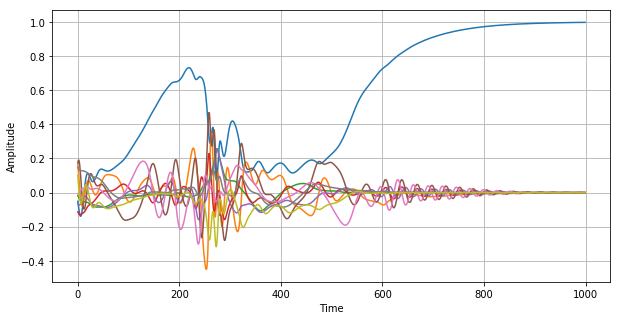

In [38]:
plt.figure(figsize=(10,5))
plt.plot(solution)
plt.grid()
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.savefig("img/solution.png",dpi=100)
plt.show()